In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import regionmask
import pandas as pd
from datetime import datetime, timedelta
import utils
from matplotlib.colors import SymLogNorm

In [15]:
ds_delta = xr.open_mfdataset(f'../GCrundirs/IRF_runs/BC_sustained/EAS/OutputDir/GEOSChem.AerosolMass.20160*', combine = 'by_coords')

In [19]:
ds_base = xr.open_mfdataset(f'../GCrundirs/IRF_runs/BC_base/CEDS/OutputDir/GEOSChem.AerosolMass.20160*', combine = 'by_coords')

In [20]:
ds_emisbase = xr.open_mfdataset(f'../GCrundirs/IRF_runs/BC_base/CEDS/OutputDir/HEMCO_diagnostics.20160*', combine = 'by_coords')

In [18]:
ds_emispulse = xr.open_mfdataset(f'../GCrundirs/IRF_runs/BC_sustained/EAS/OutputDir/HEMCO_diagnostics.20160*.nc', combine = 'by_coords')

In [22]:
ds_conc2x = xr.open_mfdataset('../GCrundirs/IRF_runs/BC_2x/2x_EAS_BC/OutputDir/GEOSChem.AerosolMass.20160*.nc4', combine = 'by_coords')
ds_emis2x = xr.open_mfdataset('../GCrundirs/IRF_runs/BC_2x/2x_EAS_BC/OutputDir/HEMCO_diagnostics.20160*', combine = 'by_coords')

In [26]:
height = pd.read_excel('gc_altitude.xlsx')

In [27]:
height_ds = height.diff().dropna().to_xarray().rename({'index':'lev'})
height_ds['lev'] = ds_base['lev']
height_ds = height_ds.rename({'altitude':'dz'}) 
height_ds['dz']*=1e3


In [28]:
ds_emisbase = xr.merge([ds_emisbase, height_ds], join = 'inner')
ds_emispulse = xr.merge([ds_emispulse, height_ds], join = 'inner')
ds_base = xr.merge([ds_base, height_ds], join = 'inner')
ds_delta = xr.merge([ds_delta, height_ds], join = 'inner')
ds_conc2x = xr.merge([ds_conc2x, height_ds], join = 'inner')
ds_emis2x = xr.merge([ds_emis2x, height_ds], join = 'inner')

In [29]:
sec_day = 86400

In [30]:
datasets = [ds_emispulse, ds_emisbase, ds_base, ds_delta, ds_conc2x, ds_emis2x]

In [31]:
for ds in [ds_emispulse, ds_emisbase,ds_emis2x]:
    utils.combine_BC(ds)

## Recreate Doubled Concentration

In [32]:
def global_w_mean(ds, variable):
    return (ds[variable].weighted(ds['AREA']*ds['dz']).mean(dim = ['lat','lon','lev']))

In [33]:
def global_sfc_w_mean(ds, variable):
    return (ds[variable].isel(lev = 0).weighted(ds['AREA']*ds['dz'].isel(lev = 0)).mean(dim = ['lat','lon']))

In [34]:
def lev_mean(ds, variable):
    return (ds[variable].weighted(ds['AREA']*ds['dz']).mean(dim = ['lev']))

In [35]:
#lev mean of G 
f = (global_w_mean(ds_emis2x, 'EmisBC_Total') - global_w_mean(ds_emisbase, 'EmisBC_Total'))
f= f.assign_coords(time = np.arange(0,len(f['time']))) #inputting a x2 until we get our doubled emissions as daily data
G = utils.calc_δc_δt_global(ds_delta, ds_base, 'AerMassBC')
G = G.assign_coords(time = np.arange(0.5,len(G['time'])+ 0.5))

f0 = (global_w_mean(ds_emispulse, 'EmisBC_Total') - 
      global_w_mean(ds_emisbase, 'EmisBC_Total'))
f0 = f0.assign_coords(time = np.arange(0.5,len(f0['time'])+0.5))


KeyboardInterrupt: 

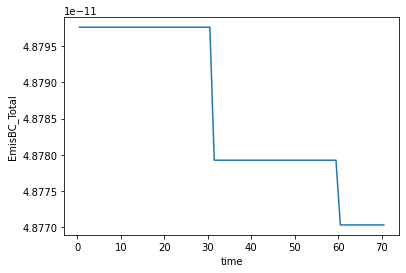

In [36]:
f0.plot()
plt.axhline(f0.mean(dim = 'time'))

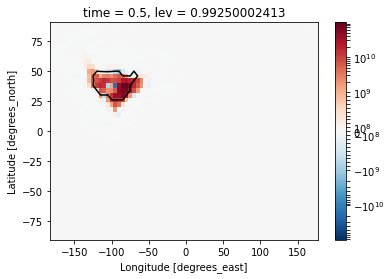

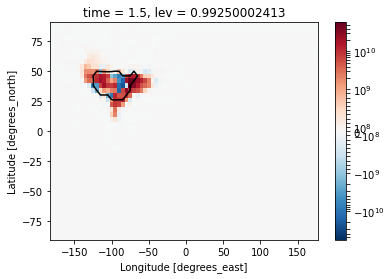

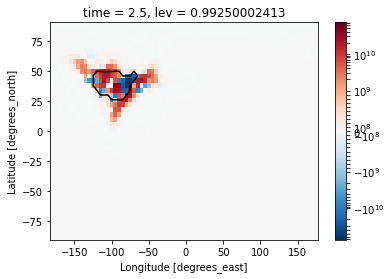

In [283]:
for t in [0,1,2]:
    fig, ax = plt.subplots()

    (ds_emis2x['EmisBC_Total']-ds_emisbase['EmisBC_Total']).isel(time = t, lev = 0).plot.contour(levels = [1e-9,np.nan], colors = 'k')
    (G/f0).isel(lev = 0, time = t).plot(norm = SymLogNorm(linthresh = 1e9))

#lev 1
f = (global_w_mean(ds_emis2x, 'EmisBC_Total') - global_w_mean(ds_emisbase, 'EmisBC_Total'))
f= f.assign_coords(time = np.arange(0,len(f['time'])))
G = (global_sfc_w_mean(ds_delta,'AerMassBC')-global_sfc_w_mean(ds_base,'AerMassBC'))
G = G.assign_coords(time = np.arange(0,len(G['time'])))

f0 = (global_w_mean(ds_emispulse, 'EmisBC_Total') - 
      global_w_mean(ds_emisbase, 'EmisBC_Total')).isel(time = 0)

```python
f = [1,2,3]
G = [1, 0.5, 0.25, 0.01]

plt.plot([t[0], t[1], t[2]], [f[0]*G[i].values*dt for i in [0, 1, 2]])
plt.plot([t[0], t[1], t[2]], [f[0]*G[i+1].values*dt for i in [0, 1, 2]] + [f[1]*G[i].values*dt for i in [0, 1, 2]])  
```

In [38]:
Ndt = 30
dt = 1 #days
tp_range = np.arange(0, dt*Ndt, dt)
t_range = tp_range+0.5
Δt = 1.


In [39]:
C_ds = xr.Dataset(
    data_vars = dict(c = (["tp","lev","lat","lon","time"], np.zeros([len(tp_range),len(ds_base['lev']),len(ds_base['lat']),len(ds_base['lon']),len(G['time'])]))),
    coords = dict(
        tp = tp_range,
        lev = ("lev", ds_base['lev']),
        lat = ("lat", ds_base['lat']),
        lon = ("lon", ds_base['lon']),
        time = G['time']
    )

)

In [40]:
for i, tp in enumerate(tp_range):
    for t in t_range:
        C_ds['c'].loc[dict(tp = tp, time = t)] = utils.G_f_kernel(G, f, t, tp,Δt, dt, f0)
        


In [41]:
C_df = C_ds.isel(lev = 0).sel(lat = 50, lon = -100, method = 'nearest').drop(['lat','lon','lev']).to_dataframe().unstack()

#testing for just a dataframe (not spatially explicit, use for lev 1)
C_df = pd.DataFrame(columns = np.arange(0, len(t_range)), index = t_range)

for i, tp in enumerate(t_range):
    for t in t_range:
        i = int(i)
        C_df[i].loc[t] = utils.G_f_kernel(G, f, t, tp,Δt, dt, f0,ds_output = False)
        


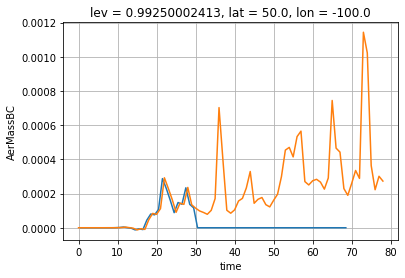

In [42]:
C_df.sum(axis = 1).plot()
(ds_conc2x['AerMassBC'].sel(lat = 50, lon = -100, method = 'nearest') - ds_base['AerMassBC'].sel(lat = 50, lon = -100, method = 'nearest')).isel(lev = 0).assign_coords(time = np.arange(0,len(ds_base['time']))).plot()
plt.grid()

/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/e

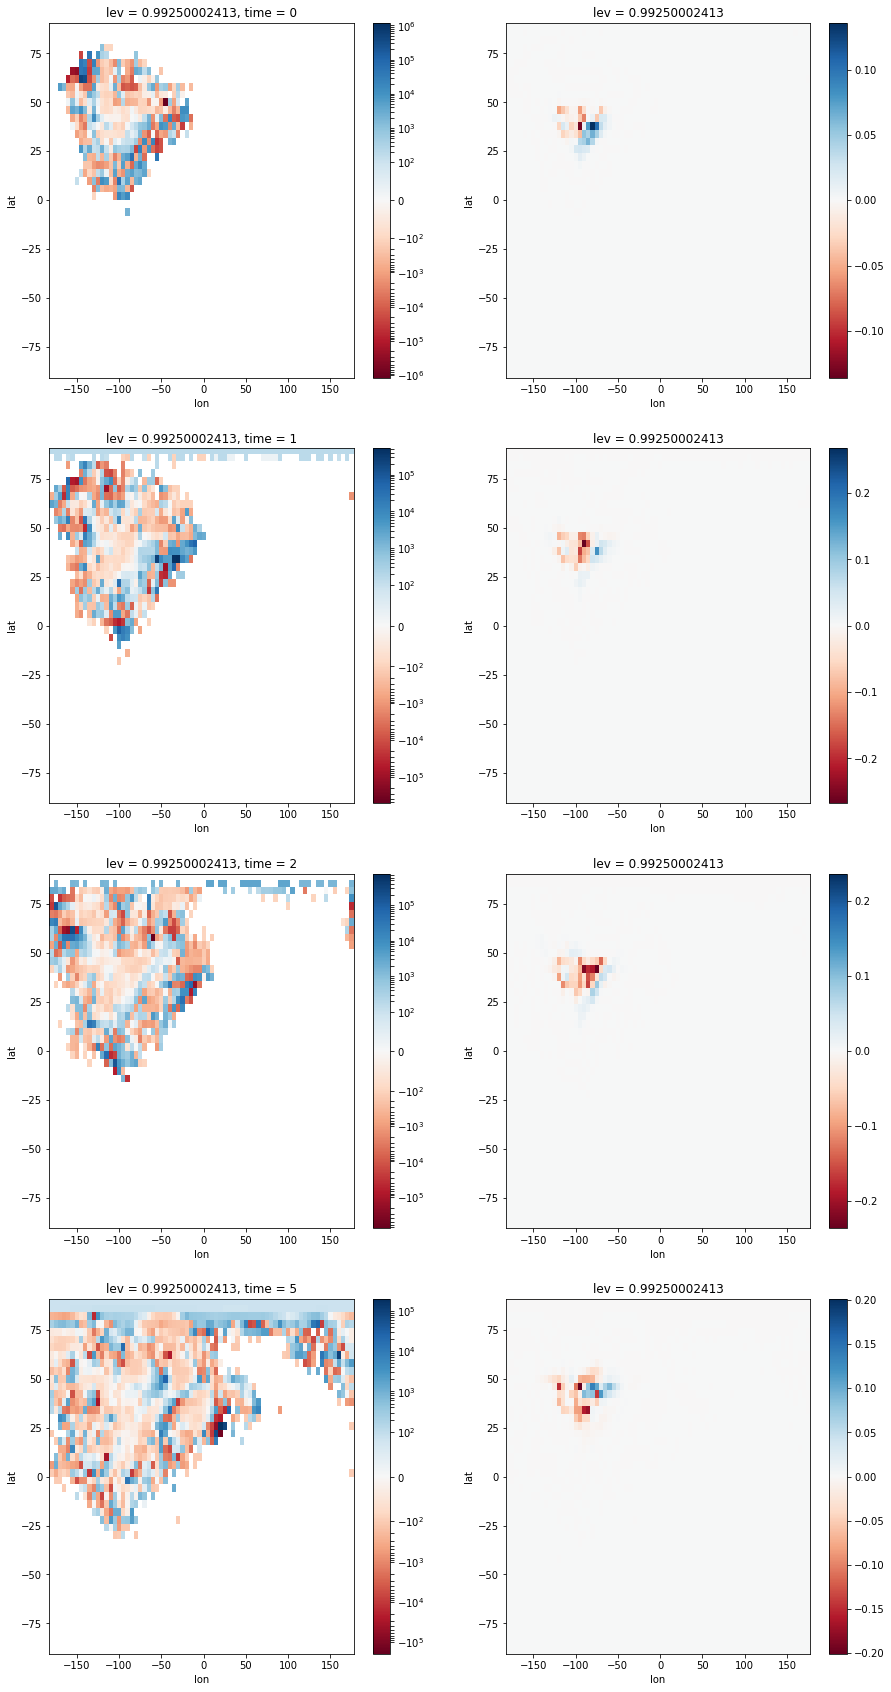

In [294]:
fig, axes = plt.subplots(4,2, figsize = [15,30])
for idx, t in enumerate([0,1,2,5]):
    lev = 0
    vmin = 0
    vmax = .05
    (((C_ds.sum(dim = 'tp').isel(lev = lev, time = t)['c'] - 
     ((ds_conc2x['AerMassBC']-ds_base['AerMassBC']).isel(lev = lev)).assign_coords(time = np.arange(0,len(ds_base['time']))).isel(time = t))/
     ((ds_conc2x['AerMassBC']-ds_base['AerMassBC']).isel(lev = lev)).assign_coords(time = np.arange(0,len(ds_base['time']))).isel(time = t))*100).plot(ax = axes[idx,0], cmap = 'RdBu', norm = SymLogNorm(linthresh = 1e2))
    
    ((C_ds.sum(dim = 'tp').isel(lev = lev, time = t)['c'] - 
     ((ds_conc2x['AerMassBC']-ds_base['AerMassBC']).isel(lev = lev)).assign_coords(time = np.arange(0,len(ds_base['time']))).isel(time = t))).plot(ax = axes[idx,1], cmap = 'RdBu')
    

/tmp/ipykernel_2252787/2997932749.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(ncols = 2, figsize = [12,5], subplot_kw={'projection':ccrs.PlateCarree()})


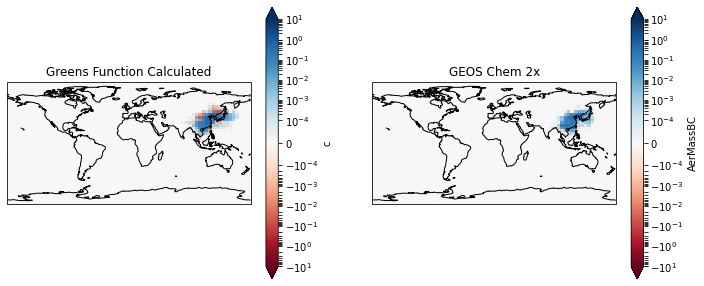

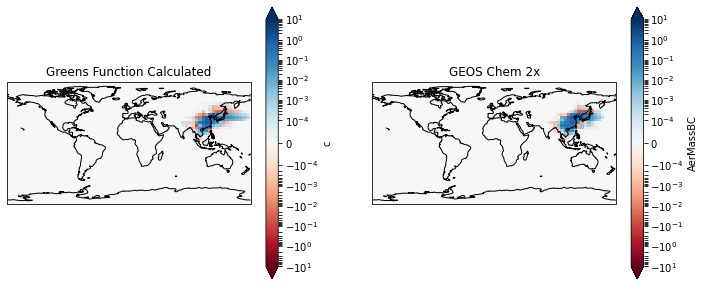

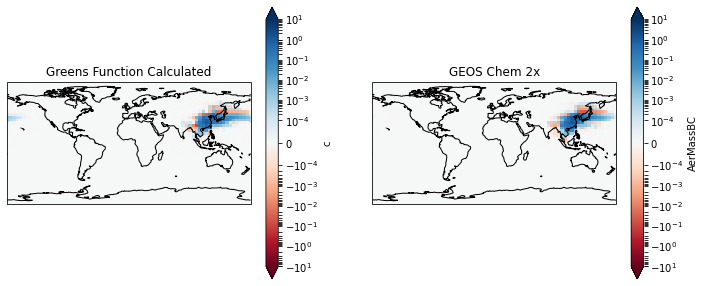

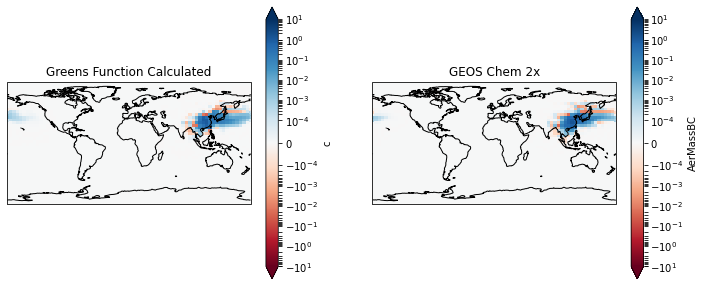

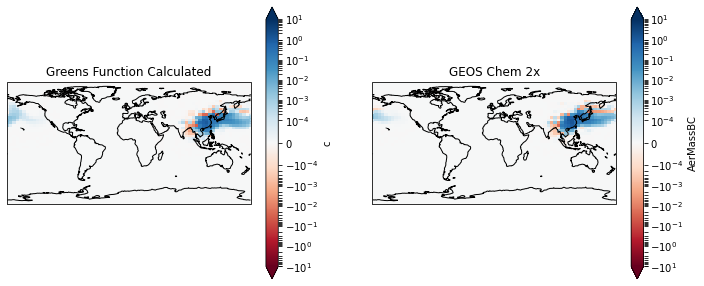

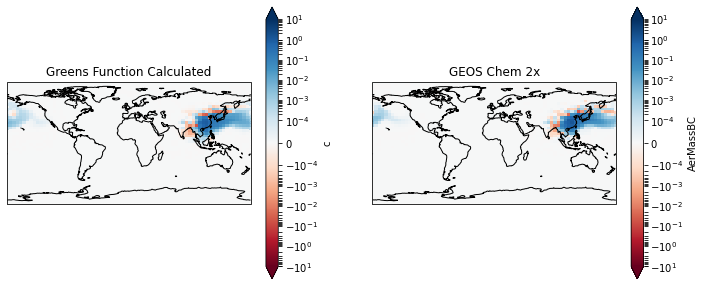

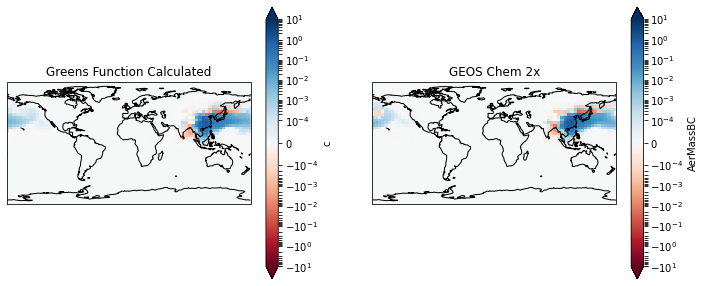

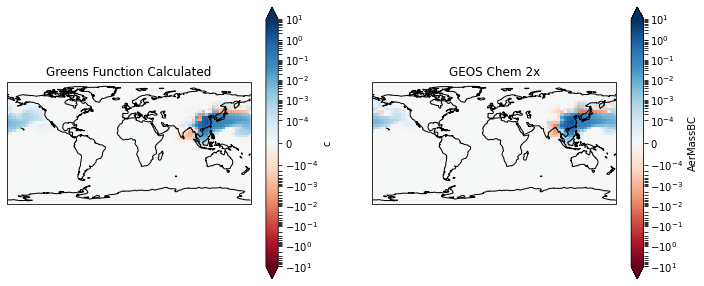

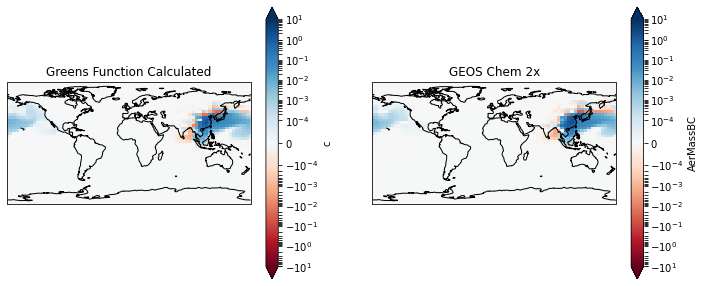

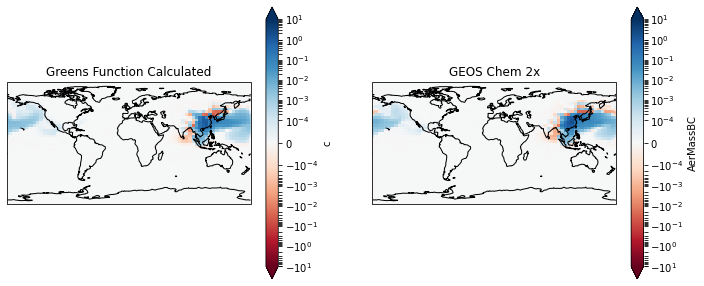

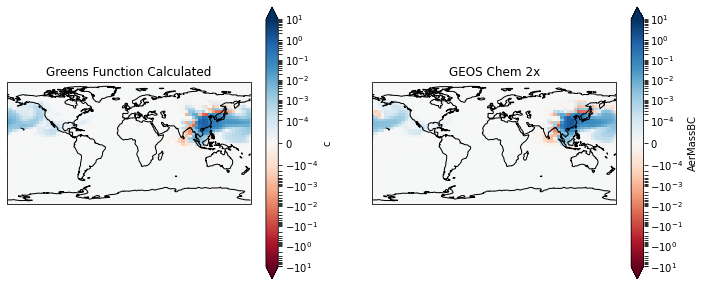

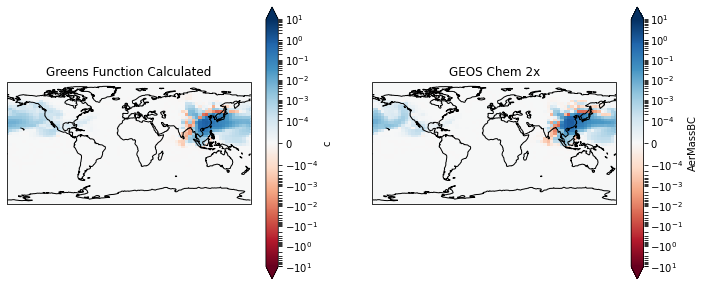

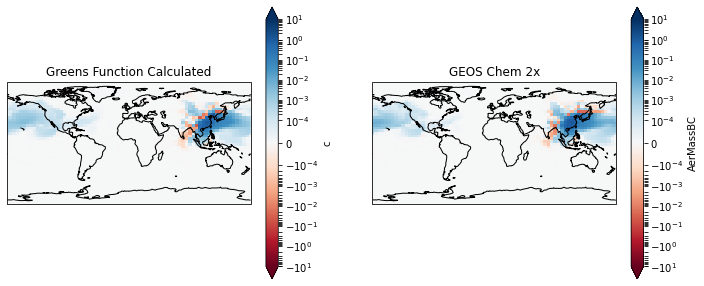

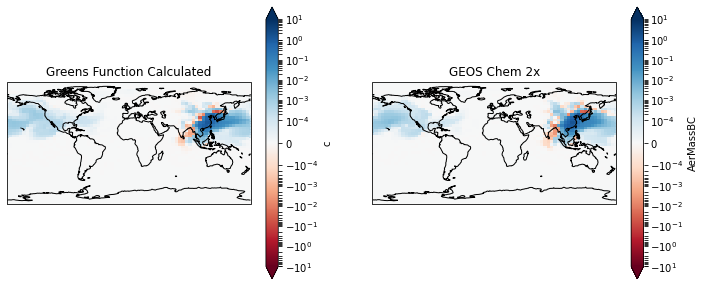

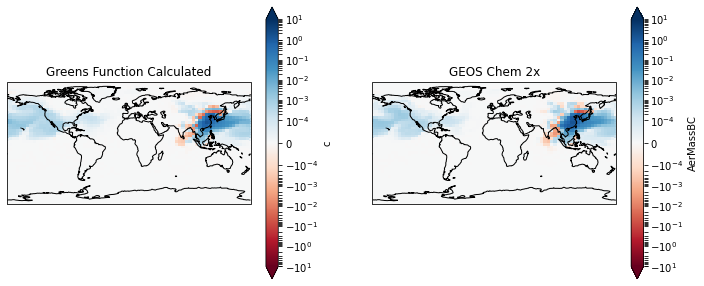

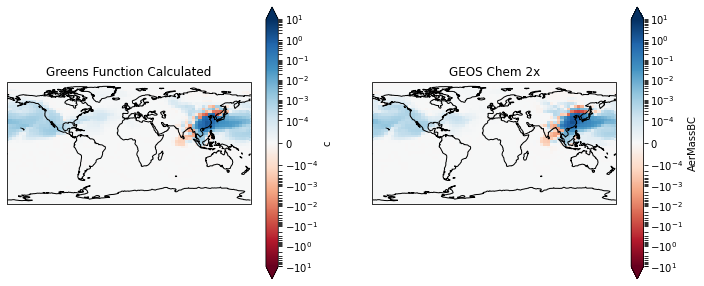

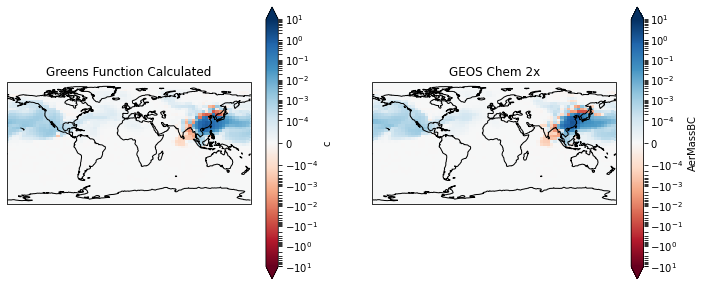

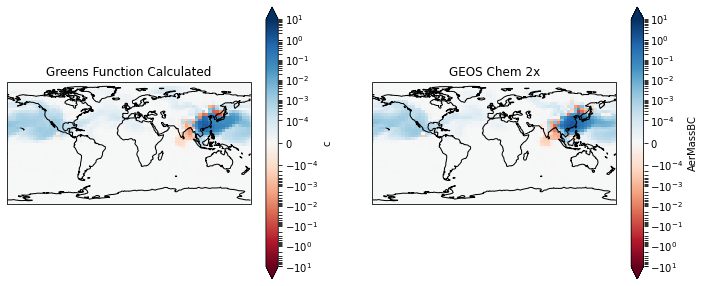

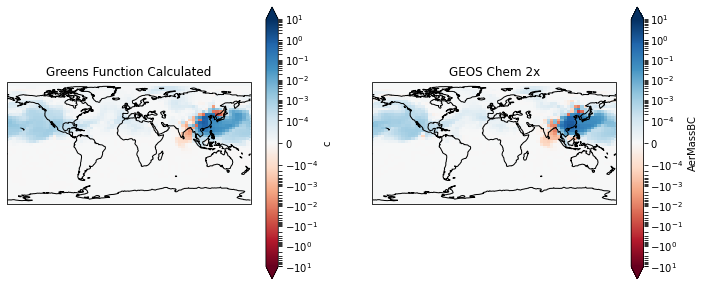

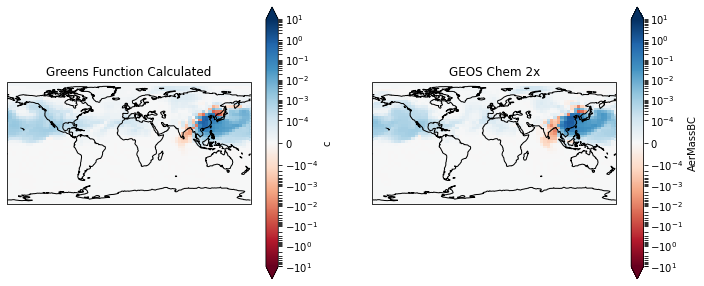

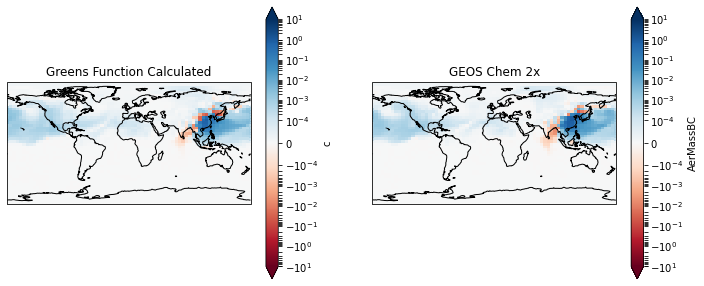

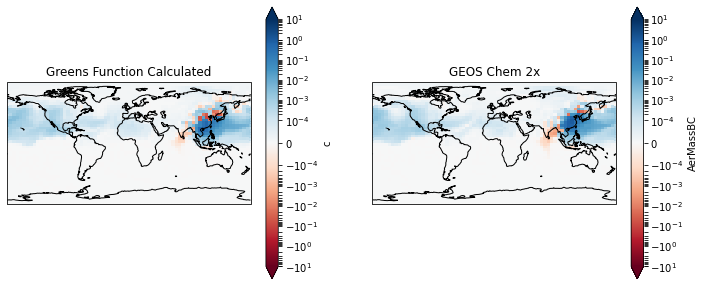

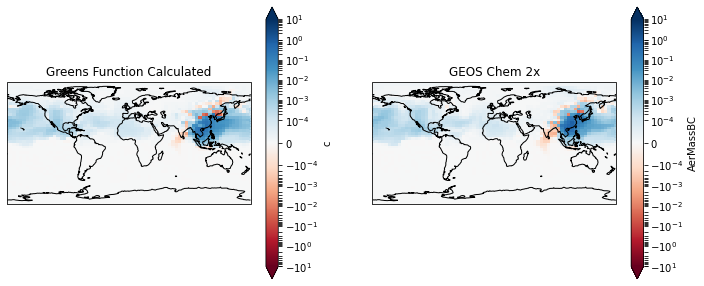

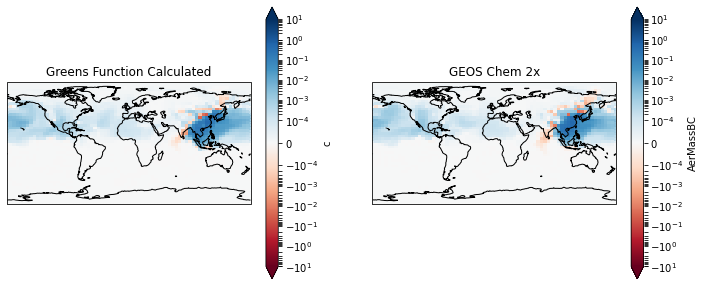

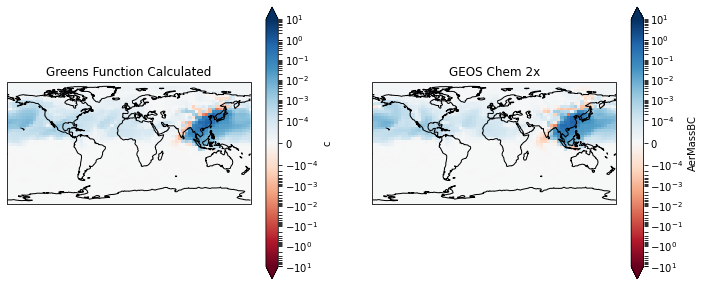

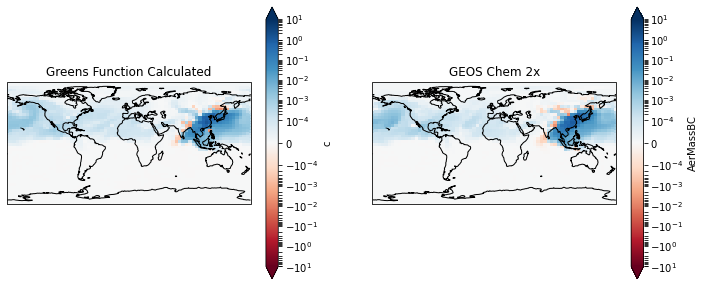

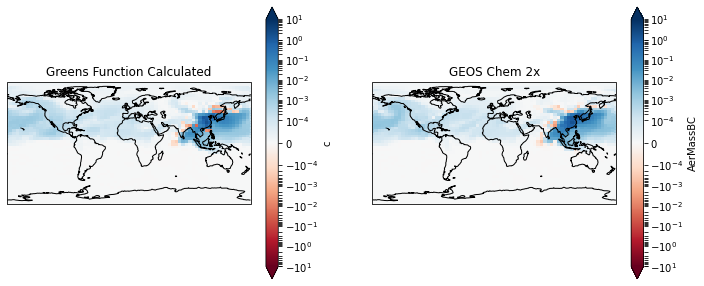

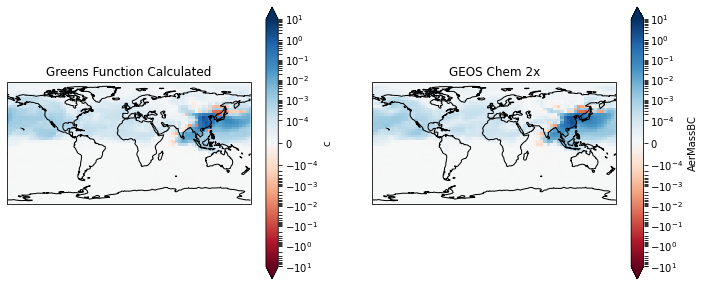

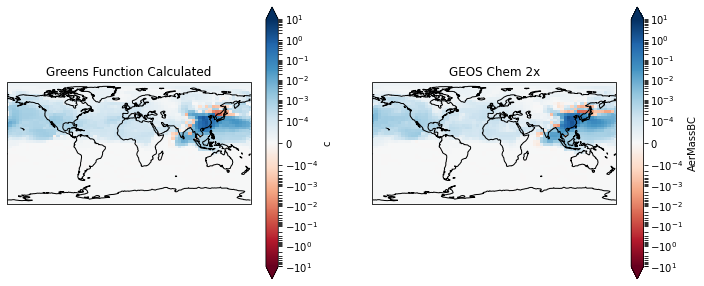

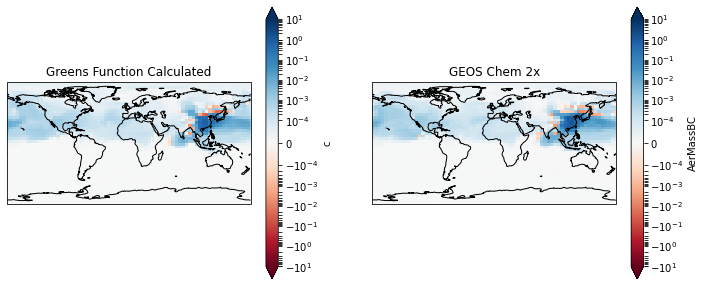

In [60]:
for t in np.arange(0,30):

    fig, axes = plt.subplots(ncols = 2, figsize = [12,5], subplot_kw={'projection':ccrs.PlateCarree()})
    vmin = 0
    vmax = .1
    C_ds.sum(dim = 'tp').isel(lev = 0, time = t)['c'].plot(ax = axes[0],
                                                           norm = SymLogNorm(linthresh = 1e-4), vmin = -10, vmax = 10,
                                                          extend = 'both', cmap = 'RdBu', transform = ccrs.PlateCarree())

    axes[0].set_title('Greens Function Calculated')
    
    
    ((ds_conc2x['AerMassBC']-ds_base['AerMassBC'])).isel(time = t, lev = 0).plot(
        ax = axes[1],
        norm = SymLogNorm(linthresh = 1e-4), vmin = -10, vmax = 10,
    extend = 'both', cmap = 'RdBu', transform = ccrs.PlateCarree())
    axes[1].set_title('GEOS Chem 2x')
    axes[0].coastlines()
    axes[1].coastlines()
    plt.savefig(f'figures/{t}_vid.png', bbox_inches = 'tight', dpi = 150)